<a href="https://colab.research.google.com/github/210124cse-jpg/CNN_implement/blob/main/210124_CNN_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# -----------------------------
# STEP 1: Clone repo (Colab)
# -----------------------------
!rm -rf CNN_implement
!git clone https://github.com/210124cse-jpg/CNN_implement.git
!ls -la CNN_implement


Cloning into 'CNN_implement'...
remote: Enumerating objects: 3271, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3271 (delta 0), reused 0 (delta 0), pack-reused 3268 (from 2)
Receiving objects: 100% (3271/3271), 121.82 MiB | 19.87 MiB/s, done.
total 3232
drwxr-xr-x 5 root root    4096 Dec 25 15:35 .
drwxr-xr-x 1 root root    4096 Dec 25 15:35 ..
-rw-r--r-- 1 root root 3284899 Dec 25 15:35 210124_CNN_implementation.ipynb
drwxr-xr-x 2 root root    4096 Dec 25 15:35 custom_data
drwxr-xr-x 5 root root    4096 Dec 25 15:35 dataset-4
drwxr-xr-x 8 root root    4096 Dec 25 15:35 .git
-rw-r--r-- 1 root root      36 Dec 25 15:35 README.md


In [26]:
# -----------------------------
# STEP 2: Install & Imports
# -----------------------------
!pip -q install scikit-learn

import os, glob, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [27]:
# -----------------------------
# STEP 3: Seed + Device
# -----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [28]:
# -----------------------------
# STEP 4: Paths
# -----------------------------
REPO_DIR = "/content/CNN_implement"
TRAIN_DIR = os.path.join(REPO_DIR, "dataset-4", "train")
TEST_DIR  = os.path.join(REPO_DIR, "dataset-4", "test")
CUSTOM_DIR = os.path.join(REPO_DIR, "custom_data")

print("TRAIN_DIR :", TRAIN_DIR)
print("TEST_DIR  :", TEST_DIR)
print("CUSTOM_DIR:", CUSTOM_DIR)
print("Custom images:", len(glob.glob(os.path.join(CUSTOM_DIR, "*.*"))))


TRAIN_DIR : /content/CNN_implement/dataset-4/train
TEST_DIR  : /content/CNN_implement/dataset-4/test
CUSTOM_DIR: /content/CNN_implement/custom_data
Custom images: 10


In [29]:
# -----------------------------
# STEP 5: Build consistent class mapping (case-insensitive)
# -----------------------------
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

def list_class_folders(root):
    classes = []
    for name in os.listdir(root):
        full = os.path.join(root, name)
        if os.path.isdir(full):
            classes.append(name)
    return classes

train_class_folders = list_class_folders(TRAIN_DIR)
canonical_classes = sorted(list({c.lower() for c in train_class_folders}))
class_to_idx = {c: i for i, c in enumerate(canonical_classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

print("Classes:", canonical_classes)
print("Num classes:", len(canonical_classes))


Classes: ['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']
Num classes: 10


In [30]:
# -----------------------------
# STEP 6: Collect samples from folders (train/test)
# -----------------------------
def collect_samples(root, class_to_idx):
    samples = []
    for folder in os.listdir(root):
        folder_path = os.path.join(root, folder)
        if not os.path.isdir(folder_path):
            continue

        cls = folder.lower()
        if cls not in class_to_idx:
            continue

        label = class_to_idx[cls]
        for fname in os.listdir(folder_path):
            if fname.lower().endswith(IMG_EXTS):
                samples.append((os.path.join(folder_path, fname), label))
    return samples

train_samples_all = collect_samples(TRAIN_DIR, class_to_idx)
test_samples = collect_samples(TEST_DIR, class_to_idx)

print("Train samples:", len(train_samples_all))
print("Test samples :", len(test_samples))

if len(train_samples_all) == 0 or len(test_samples) == 0:
    raise ValueError("No images found in train/test. Check your dataset-4 folder structure.")


Train samples: 2301
Test samples : 922


In [31]:
# -----------------------------
# STEP 7: Transforms
# -----------------------------
IMG_SIZE = 160

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.12, contrast=0.12, saturation=0.12),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


In [32]:
# -----------------------------
# STEP 8: Dataset class (from samples list)
# -----------------------------
class SamplesDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label, path


In [33]:
# -----------------------------
# STEP 9: Train/Val split (80/20) with fixed seed
# -----------------------------
val_ratio = 0.2
n = len(train_samples_all)

rng = np.random.default_rng(SEED)
indices = np.arange(n)
rng.shuffle(indices)

val_size = int(n * val_ratio)
val_idx = indices[:val_size]
train_idx = indices[val_size:]

train_samples = [train_samples_all[i] for i in train_idx]
val_samples   = [train_samples_all[i] for i in val_idx]

train_set = SamplesDataset(train_samples, transform=train_tfms)
val_set   = SamplesDataset(val_samples,   transform=eval_tfms)
test_set  = SamplesDataset(test_samples,  transform=eval_tfms)

print("Train:", len(train_set), "Val:", len(val_set), "Test:", len(test_set))


Train: 1841 Val: 460 Test: 922


In [34]:
# -----------------------------
# STEP 10: DataLoaders
# -----------------------------
BATCH_SIZE = 32

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


In [35]:
# -----------------------------
# STEP 11: CNN model
# -----------------------------
NUM_CLASSES = len(canonical_classes)

class BetterCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),  # 160 -> 80

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),  # 80 -> 40

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),  # 40 -> 20

            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)

model = BetterCNN(NUM_CLASSES).to(device)
model


BetterCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [36]:
# =========================
# STEP 12: Training setup
# =========================

EPOCHS = 20
LR = 1e-3

criterion = nn.CrossEntropyLoss(label_smoothing=0.02)

optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=3
)

print("Step 12 setup done ✅")
print("Initial LR:", optimizer.param_groups[0]["lr"])


Step 12 setup done ✅
Initial LR: 0.001


In [37]:
# -----------------------------
# STEP 13: Train + Validate (save best model)
# -----------------------------
def run_epoch(model, loader, train_mode=True):
    model.train() if train_mode else model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels, _ in loader:
        images, labels = images.to(device), labels.to(device)

        if train_mode:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train_mode):
            outputs = model(images)
            loss = criterion(outputs, labels)

            if train_mode:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, 100.0 * correct / total

train_losses, train_accs = [], []
val_losses, val_accs = [], []

best_val_acc = 0.0
best_state = None

for epoch in range(EPOCHS):
    tr_loss, tr_acc = run_epoch(model, train_loader, train_mode=True)
    va_loss, va_acc = run_epoch(model, val_loader,   train_mode=False)

    train_losses.append(tr_loss); train_accs.append(tr_acc)
    val_losses.append(va_loss);   val_accs.append(va_acc)

    scheduler.step(va_acc)

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch+1:02d}/{EPOCHS} | "
          f"Train Loss {tr_loss:.4f} Acc {tr_acc:.2f}% | "
          f"Val Loss {va_loss:.4f} Acc {va_acc:.2f}%")

model.load_state_dict(best_state)
model.to(device)
print("Loaded best model ✅ Val Acc:", best_val_acc)


Epoch 01/20 | Train Loss 1.8519 Acc 36.23% | Val Loss 1.6939 Acc 45.87%
Epoch 02/20 | Train Loss 1.5746 Acc 48.56% | Val Loss 1.5555 Acc 48.48%
Epoch 03/20 | Train Loss 1.4844 Acc 52.36% | Val Loss 1.4567 Acc 53.48%
Epoch 04/20 | Train Loss 1.3847 Acc 55.08% | Val Loss 1.3768 Acc 58.26%
Epoch 05/20 | Train Loss 1.3593 Acc 57.52% | Val Loss 1.3612 Acc 56.09%
Epoch 06/20 | Train Loss 1.3237 Acc 57.36% | Val Loss 1.2202 Acc 63.48%
Epoch 07/20 | Train Loss 1.2749 Acc 59.04% | Val Loss 1.2138 Acc 62.39%
Epoch 08/20 | Train Loss 1.2756 Acc 59.37% | Val Loss 1.2171 Acc 61.09%
Epoch 09/20 | Train Loss 1.2233 Acc 61.27% | Val Loss 1.3123 Acc 54.78%
Epoch 10/20 | Train Loss 1.2026 Acc 62.57% | Val Loss 1.2606 Acc 57.61%
Epoch 11/20 | Train Loss 1.1351 Acc 64.42% | Val Loss 1.1111 Acc 64.57%
Epoch 12/20 | Train Loss 1.1114 Acc 67.35% | Val Loss 1.2403 Acc 58.91%
Epoch 13/20 | Train Loss 1.0802 Acc 68.06% | Val Loss 1.1064 Acc 64.78%
Epoch 14/20 | Train Loss 1.0795 Acc 66.27% | Val Loss 1.0438 Acc

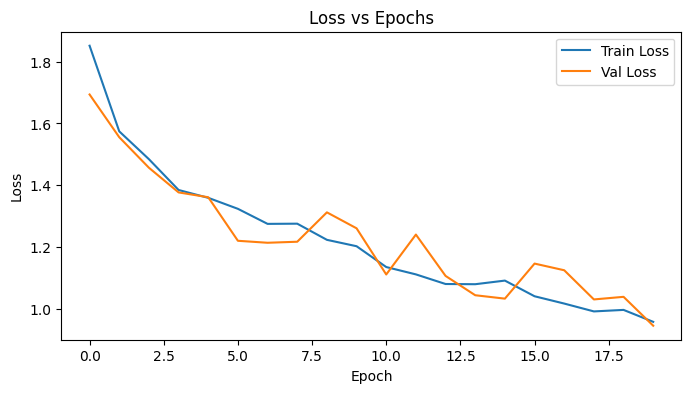

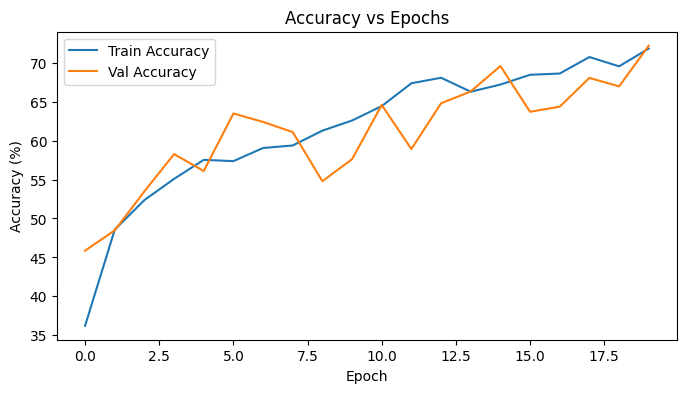

In [38]:
# -----------------------------
# STEP 14: Plot Loss vs Epochs & Accuracy vs Epochs (Train + Val)
# -----------------------------
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()


TEST Accuracy: 68.76%


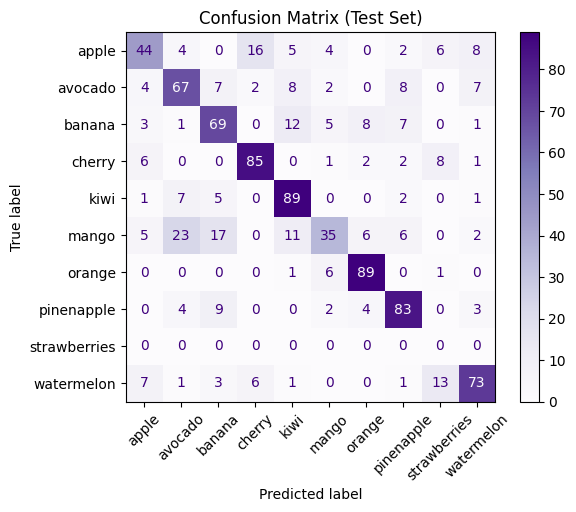

In [39]:
# -----------------------------
# STEP 15: Test Accuracy + Confusion Matrix (TEST set)
# -----------------------------
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels, _ in test_loader:
        outputs = model(images.to(device))
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

test_acc = 100.0 * (all_preds == all_labels).mean()
print(f"TEST Accuracy: {test_acc:.2f}%")

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=canonical_classes)
disp.plot(cmap="Purples",xticks_rotation=45, values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.show()


Collected: 10 correct, 3 incorrect


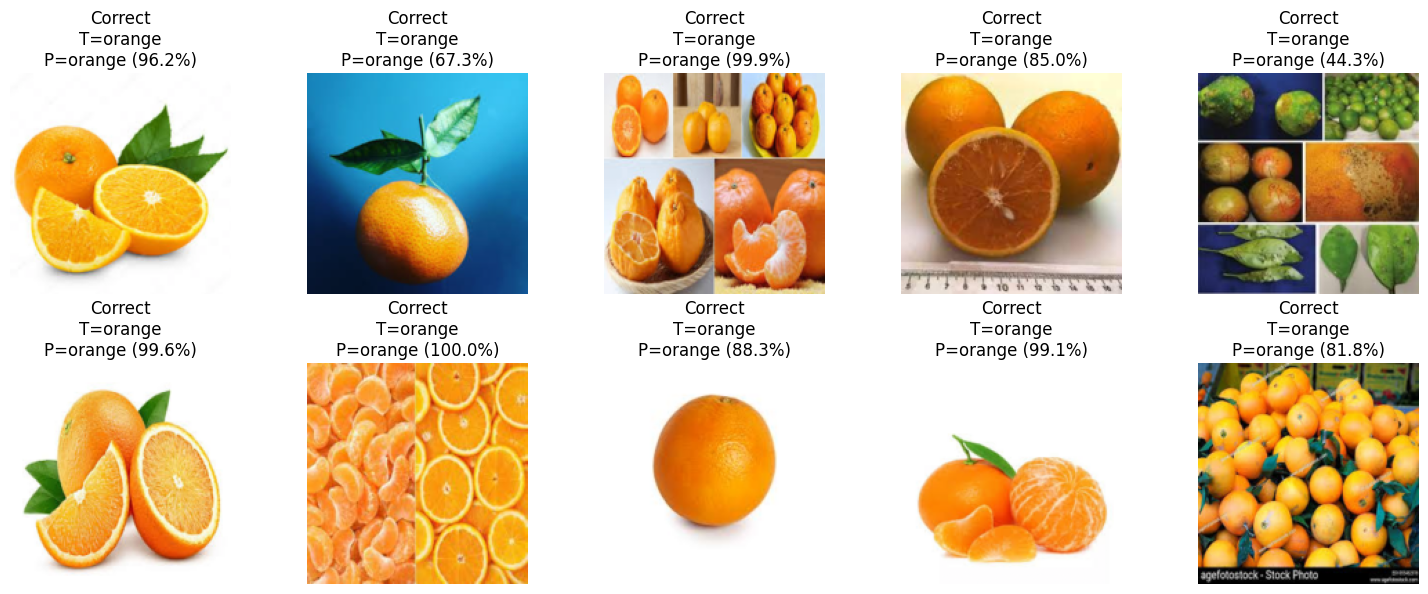

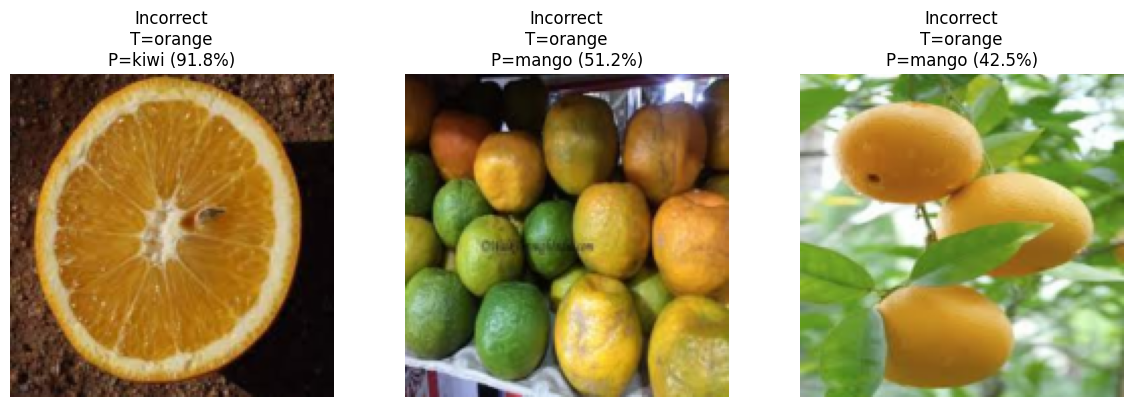

In [40]:
# -----------------------------
# STEP 16: Show 10 Correct + 3 Incorrect predictions (TEST set)
# -----------------------------
def unnormalize(img_t):
    img = img_t.clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return torch.clamp(img, 0, 1)

def show_tensor(img_tensor):
    img_tensor = unnormalize(img_tensor)
    img = img_tensor.permute(1,2,0).numpy()
    plt.imshow(img)
    plt.axis("off")

correct_examples = []
incorrect_examples = []

model.eval()
with torch.no_grad():
    for images, labels, paths in test_loader:
        outputs = model(images.to(device))
        probs = torch.softmax(outputs, dim=1).cpu()
        preds = probs.argmax(dim=1)

        for i in range(images.size(0)):
            t = labels[i].item()
            p = preds[i].item()
            conf = probs[i, p].item()

            if t == p and len(correct_examples) < 10:
                correct_examples.append((images[i].cpu(), t, p, conf, paths[i]))
            if t != p and len(incorrect_examples) < 3:
                incorrect_examples.append((images[i].cpu(), t, p, conf, paths[i]))

            if len(correct_examples) >= 10 and len(incorrect_examples) >= 3:
                break
        if len(correct_examples) >= 10 and len(incorrect_examples) >= 3:
            break

print("Collected:", len(correct_examples), "correct,", len(incorrect_examples), "incorrect")

# Plot 10 correct
plt.figure(figsize=(15,6))
for k, (img, t, p, conf, path) in enumerate(correct_examples):
    plt.subplot(2,5,k+1)
    show_tensor(img)
    plt.title(f"Correct\nT={idx_to_class[t]}\nP={idx_to_class[p]} ({conf*100:.1f}%)")
plt.tight_layout()
plt.show()

print("\n\n\n")

# Plot 3 incorrect
plt.figure(figsize=(12,4))
for k, (img, t, p, conf, path) in enumerate(incorrect_examples):
    plt.subplot(1,3,k+1)
    show_tensor(img)
    plt.title(f"Incorrect\nT={idx_to_class[t]}\nP={idx_to_class[p]} ({conf*100:.1f}%)")
plt.tight_layout()
plt.show()


Custom files: ['apple.jpg', 'avocado.jpg', 'banana.jpg', 'cherry.jpg', 'kiwi.jpg', 'mango.jpg', 'orange.jpg', 'pineapple.jpg', 'strawberry.jpg', 'watermelon.jpg']


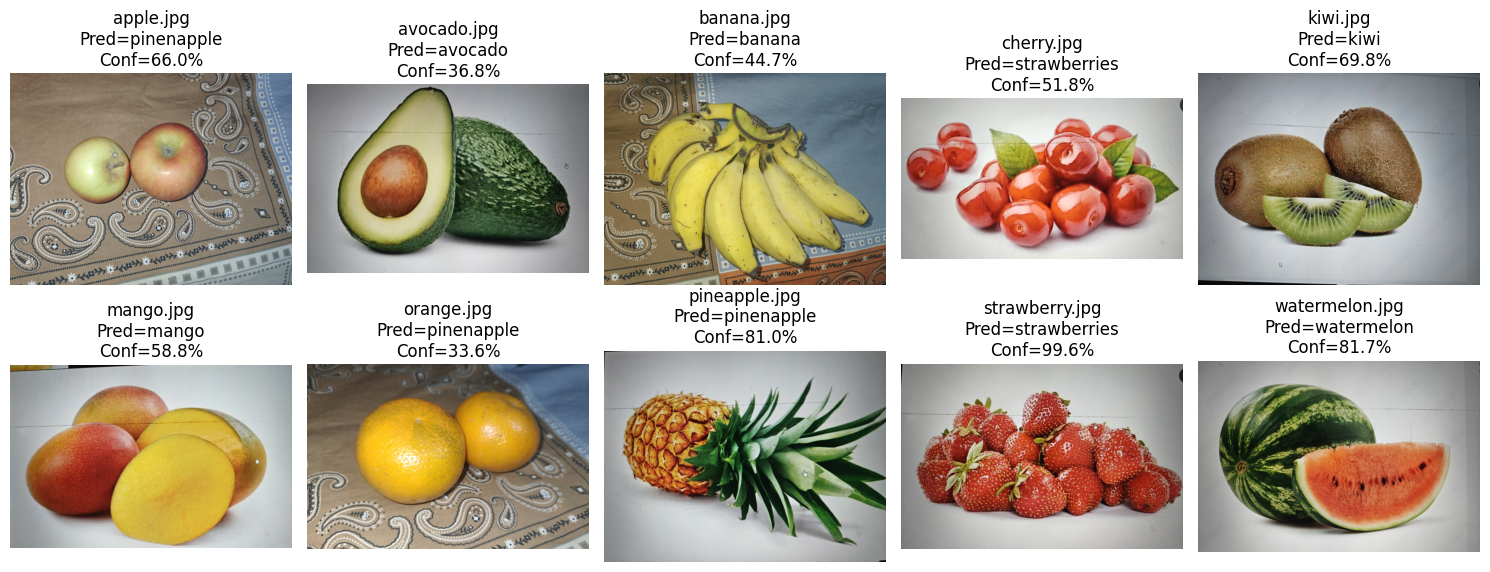

In [43]:
# -----------------------------
# STEP 17: Predict 10 custom images (custom_data) + confidence
# -----------------------------
custom_files = sorted([f for f in glob.glob(os.path.join(CUSTOM_DIR, "*"))
                       if f.lower().endswith(IMG_EXTS)])[:10]

print("Custom files:", [os.path.basename(x) for x in custom_files])

model.eval()
plt.figure(figsize=(15,6))

for i, f in enumerate(custom_files):
    img = Image.open(f).convert("RGB")
    x = eval_tfms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(x)
        prob = torch.softmax(out, dim=1)[0].cpu().numpy()
        pred = int(np.argmax(prob))
        conf = float(prob[pred])

    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{os.path.basename(f)}\nPred={idx_to_class[pred]}\nConf={conf*100:.1f}%")

plt.tight_layout()
plt.show()


In [42]:
# -----------------------------
# STEP 18: Save model weights as model/210124.pth + reload check
# -----------------------------
STUDENT_ID = "210124"
MODEL_DIR = os.path.join(REPO_DIR, "model")
os.makedirs(MODEL_DIR, exist_ok=True)

save_path = os.path.join(MODEL_DIR, f"{STUDENT_ID}.pth")
torch.save(model.state_dict(), save_path)
print("Saved model to:", save_path)

model2 = BetterCNN(NUM_CLASSES).to(device)
model2.load_state_dict(torch.load(save_path, map_location=device))
model2.eval()
print("Reload successful ✅")
